**MIMO PROTOYPE**:

Here we try our hand at making MIMO work, and testing its validity with a synthetic toy dataset. The notebook contains the following: 
- Create toy dataset and dataloaders - toy regression data & MNIST?
- Simple MIMO model - regression and classification
- Training and results on toy dataset

For the classification task, we make the following plots:
- Reliability: confidence vs error - for classification
- Expected calibration errors - for classification
- Diveristity plots - for classification and regression

For the regression task, we plot the mean prediction and a 95% confidence interval.

In [1]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
# from sklearn.manifold import TSNE


def set_seed(seed=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(1871)

# Regression

***Making the dataset***

We start by making a toy dataset, which will enable us to better understand the network. Since we have full control over the data, we can see how changes impact MIMO.

The most basic problems we can solve with a MIMO-configured neural network is regression. Classification would also be a somewhat simple problem to solve. 

We first generate training data from the function
$$y = x + 0.3 \sin{(2\pi (x+ \epsilon)) + 0.3 \sin{(4\pi (x+\epsilon))}} $$
as described by Blundell et al.

We use $N_{train}=500$ training points and $N_{test}$ testing points. 

In [2]:
# Regression data function
f = lambda x, epsilon: x + 0.3 * np.sin(2*np.pi * (x+epsilon)) + 0.3 * np.sin(4 * np.pi * (x+epsilon)) + epsilon

def generate_data(N, lower, upper, std, f=f):
    # create data
    x = np.linspace(lower, upper, N)

    y = []
    for i in range(N):
        epsilon = np.random.normal(0, std)
        y.append(f(x[i], epsilon))
    return x, y

# Generate train data
N_train = 2000
x, y = generate_data(N_train, lower=-0.25, upper=1, std=0.02)

# Generate validation data
N_val = 500
x_val, y_val = generate_data(N_val, lower=-0.25, upper=1, std=0.02)

# Generate test data
N_test = 500
x_test, y_test = generate_data(N_test, lower=-0.5, upper=1.5, std=0.02)

line = f(x_test, 0)

We make a custom toy dataset class for the MIMO model. During training, the $M$ subnetworks in the model each get a different batch of training samples. We can do this by multiplying the batch size with a factor $M$ such that the effective batch size is:
$$
batch\_size^* = \frac{batch\_size}{M}
$$
This is implemented using a custom collate function.

During inference, the $M$ subnetworks in the model each get the same input. We implement this by multiplying the input $M$ times using another collate function.

In [3]:
class ToyDataset(Dataset):
    """Custom toy dataset"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):

        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)
    
def train_collate_fn(batch, M):
    """Collate function for training MIMO"""
    
    x, y = zip(*batch)
    
    x_chunks = torch.stack(torch.chunk(torch.tensor(x), M, dim=0), dim=1)
    y_chunks = torch.stack(torch.chunk(torch.tensor(y), M, dim=0), dim=1)

    return x_chunks, y_chunks

def test_collate_fn(batch, M):
    """Collate function for testing MIMO"""
    
    x, y = zip(*batch)
    x = torch.tensor(x)[:,None].repeat(1,M)
    y = torch.tensor(y)[:,None].repeat(1,M)

    return x, y

def naive_collate_fn(batch, M):
    """Collate function for naive multiheaded model"""

    x, y = zip(*batch)
    x = torch.tensor(x)[:,None]
    y = torch.tensor(y)[:,None].repeat(1,M)

    return x, y

In [4]:
# seed workers for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

M = 2
traindata = ToyDataset(x, y)
trainloader = DataLoader(traindata, batch_size=60*M, shuffle=True, collate_fn=lambda x: train_collate_fn(x, M), drop_last=True, worker_init_fn=seed_worker, generator=g)
naivetrainloader = DataLoader(traindata, batch_size=60, shuffle=True, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False, worker_init_fn=seed_worker, generator=g)

valdata = ToyDataset(x_val, y_val)
valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)
naivevalloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)

testdata = ToyDataset(x_test, y_test)
testloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)
naivetestloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)



# Dataloader properties
Testing shape of output from train and test loaders

The ``trainloader`` should output a batch where columns are different.

In [5]:
for x_train,y_train in trainloader:
    print(x_train.shape)
    print(y_train.shape)
    break

print(x_train)

torch.Size([60, 2])
torch.Size([60, 2])
tensor([[ 0.3334,  0.3647],
        [ 0.8218, -0.1625],
        [ 0.0033,  0.6523],
        [ 0.9725,  0.3953],
        [ 0.5748,  0.2915],
        [ 0.1271, -0.0361],
        [ 0.1733,  0.7605],
        [-0.0862,  0.6361],
        [ 0.4035,  0.6286],
        [ 0.7074,  0.6473],
        [ 0.4353,  0.3628],
        [ 0.2090,  0.0220],
        [ 0.6342,  0.5329],
        [-0.2375,  0.5341],
        [ 0.1264,  0.9800],
        [ 0.4491,  0.0883],
        [ 0.9969,  0.1358],
        [ 0.8487,  0.8237],
        [ 0.3566,  0.6655],
        [-0.1056,  0.8212],
        [ 0.8199,  0.9156],
        [ 0.7224,  0.3534],
        [-0.0036,  0.8337],
        [-0.2250,  0.9287],
        [ 0.7336,  0.2159],
        [ 0.8718,  0.3553],
        [-0.1981,  0.4422],
        [-0.1606,  0.7067],
        [ 0.3309,  0.3797],
        [ 0.4772,  0.7968],
        [ 0.8524,  0.7518],
        [ 0.9337,  0.2177],
        [ 0.1121, -0.0680],
        [ 0.2284,  0.9306],
        

The MIMO dataloaders should output a batch with size $(batch\_size, M)$

In [6]:
for test_x, test_y in testloader:
    print(test_x.shape)
    print(test_y.shape)
    break


torch.Size([500, 2])
torch.Size([500, 2])


The dataloader for the naive multiheaded model should output a batch with size $(batch\_size, 1)$ for the features $x$ and labels (batch_size, M) for $y$.

In [7]:
for naive_x_train, naive_y_train in naivetrainloader:
    print(naive_x_train.shape)
    print(naive_y_train.shape)
    break


torch.Size([60, 1])
torch.Size([60, 2])


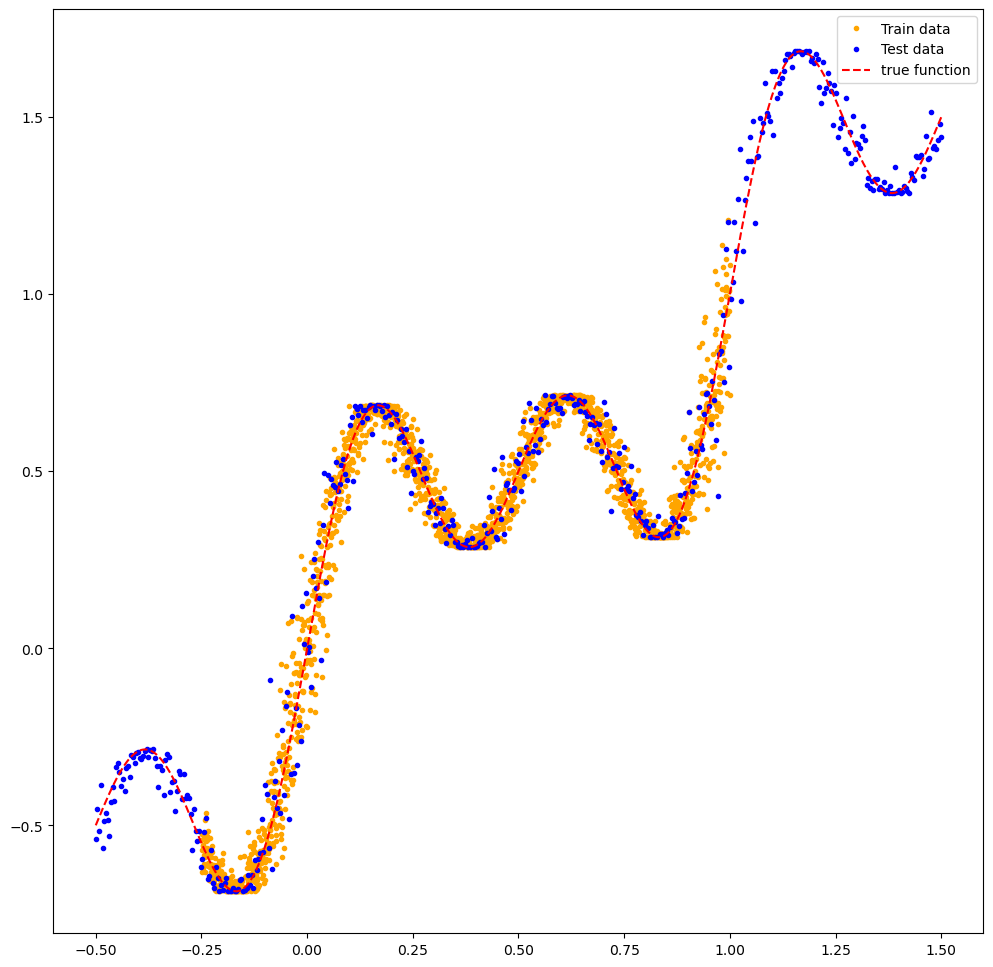

In [8]:
# plot data
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.plot(x, y, '.', label='Train data', color='orange')
ax.plot(x_test, y_test, '.', label='Test data', color='blue')
ax.plot(x_test, line, '--', label='true function', color='red')
ax.legend()
plt.show()

***Building the model***

The model is a MIMO configured neural network. To keep it simple for now we choose to have $M=2$, so we use 2 subnetworks.
The neural network will consist of two feed-forward aka linear layers with 32 and 128 hidden units in each. For activation function we will use ReLU as it is the norm within the field.

We choose the number of hidden units we did, so that our architecture would be the same as the one given in the MIMO paper when they fit a MIMO model to this synthetic data.

We make sure that we can get both the averaged output (ensemble output) and individual ensemble member output. This will help us illustrate the diversity of the ensemble members.

In [12]:
# Define the model
hidden_units = 32
hidden_units2 = 128

def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

class VarMIMONetwork(nn.Module):
    def __init__(self, n_subnetworks, hidden_units=32, hidden_units2=128):
        super().__init__()
        self.n_subnetworks = n_subnetworks
        self.model = torch.nn.Sequential(
            nn.Linear(self.n_subnetworks, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, self.n_subnetworks*2)
        )

    def get_sigma(self, rho):
        return torch.log1p(torch.exp(rho))

    def forward(self, x):
        individual_outputs = self.model(x)
        # mus and sigmas for each subnetwork
        mus = individual_outputs[:,:self.n_subnetworks]
        sigmas = self.get_sigma(individual_outputs[:,self.n_subnetworks:])

        # compute mu and sigma for mixture model with M gaussian
        # https://stats.stackexchange.com/a/445232
        mu = torch.mean(mus, dim=1)
        sigma = (torch.mean((mus.pow(2) + sigmas.pow(2)), dim=1) - mu.pow(2)).sqrt()
        
        return mu, sigma, mus, sigmas

MIMO_model = VarMIMONetwork(n_subnetworks=M)
MIMO_model.apply(init_weights)

class VarNaiveNetwork(nn.Module):
    def __init__(self, n_subnetworks):
        super().__init__()
        self.n_subnetworks = n_subnetworks
        self.model = torch.nn.Sequential(
            nn.Linear(1, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, self.n_subnetworks*2)
        )
    def get_sigma(self, rho):
        return torch.log1p(torch.exp(rho))

    def forward(self, x):
        individual_outputs = self.model(x)
        # mus and sigmas for each subnetwork
        mus = individual_outputs[:,:self.n_subnetworks]
        sigmas = self.get_sigma(individual_outputs[:,self.n_subnetworks:])

        # compute mu and sigma for mixture model with M gaussian
        # https://stats.stackexchange.com/a/445232
        mu = torch.mean(mus, dim=1)
        sigma = (torch.mean((mus.pow(2) + sigmas.pow(2)), dim=1) - mu.pow(2)).sqrt()

        return mu, sigma, mus, sigmas

naive_model = VarNaiveNetwork(n_subnetworks=M)
naive_model.apply(init_weights)

VarNaiveNetwork(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
)

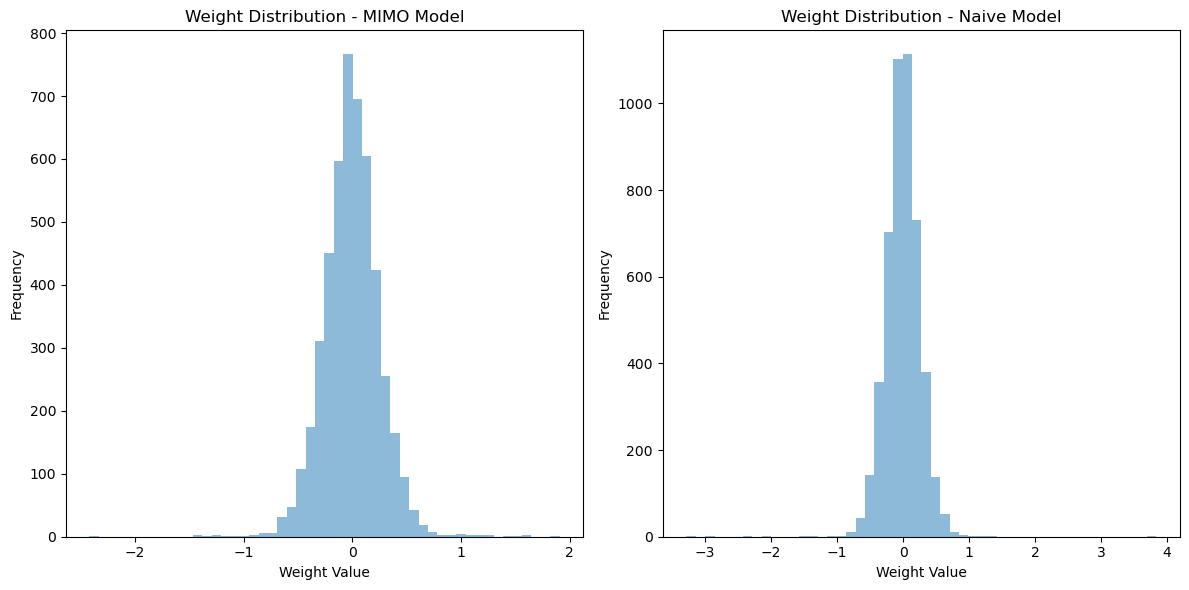

In [13]:
# weight distribution

weights_mimo = []
for param in MIMO_model.parameters():
    weights_mimo.extend(param.flatten().detach().numpy())

weights_naive = []
for param in naive_model.parameters():
    weights_naive.extend(param.flatten().detach().numpy())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(weights_mimo, bins=50, alpha=0.5, label='MIMO_model')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Weight Distribution - MIMO Model')

ax2.hist(weights_naive, bins=50, alpha=0.5, label='naive_model')
ax2.set_xlabel('Weight Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Weight Distribution - Naive Model')

plt.tight_layout()
plt.show()

In [17]:
def train_var_regression(model, optimizer, trainloader, valloader, epochs=500, model_name='MIMO', val_every_n_epochs=10):

    losses = []
    val_losses = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            model.train()

            x_,y_ = x_.float(), y_.float()

            optimizer.zero_grad()

            mu, sigma, mus, sigmas = model(x_)
            loss = torch.nn.GaussianNLLLoss(reduction='mean')(mus, y_, sigmas)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())  

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float(), val_y.float()
                    val_mu, val_sigma, val_mus, val_sigmas = model(val_x)
                    val_loss = torch.nn.GaussianNLLLoss(reduction='mean')(val_mus, val_y, val_sigmas)
                    val_loss_list.append(val_loss.item())

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                # torch.save(model, f'models/{model_name}.pt')
                torch.save(model, f'{model_name}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")

    return losses, val_losses

def plot_loss(losses, val_losses):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].plot(losses, label='Train loss')
    ax[0].set_title('Train loss')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Loss')
    ax[0].grid()

    ax[1].plot(val_losses, label='Validation loss', color='orange')
    ax[1].set_title('Validation loss')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Loss')
    ax[1].grid()

    plt.show()

We train one MIMO model and one Naive model with $M=[2,3,4,5]$ subnetworks. 

  0%|          | 0/5000 [00:00<?, ?it/s]

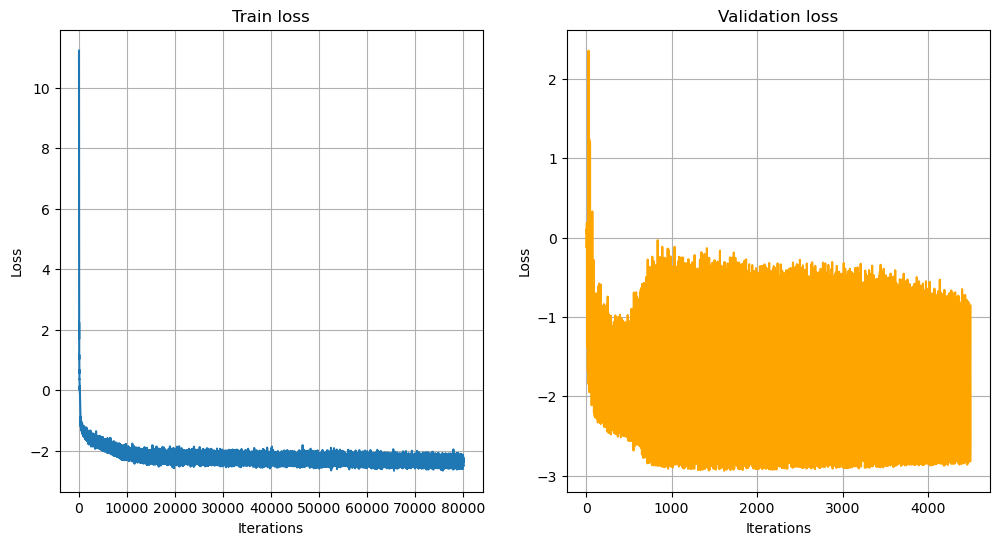

  0%|          | 0/5000 [00:00<?, ?it/s]

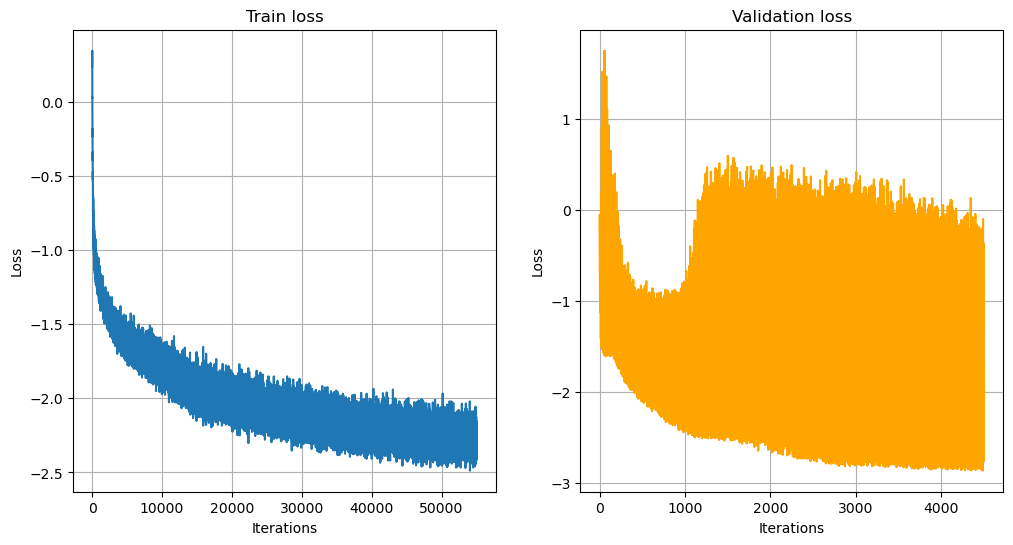

  0%|          | 0/5000 [00:00<?, ?it/s]

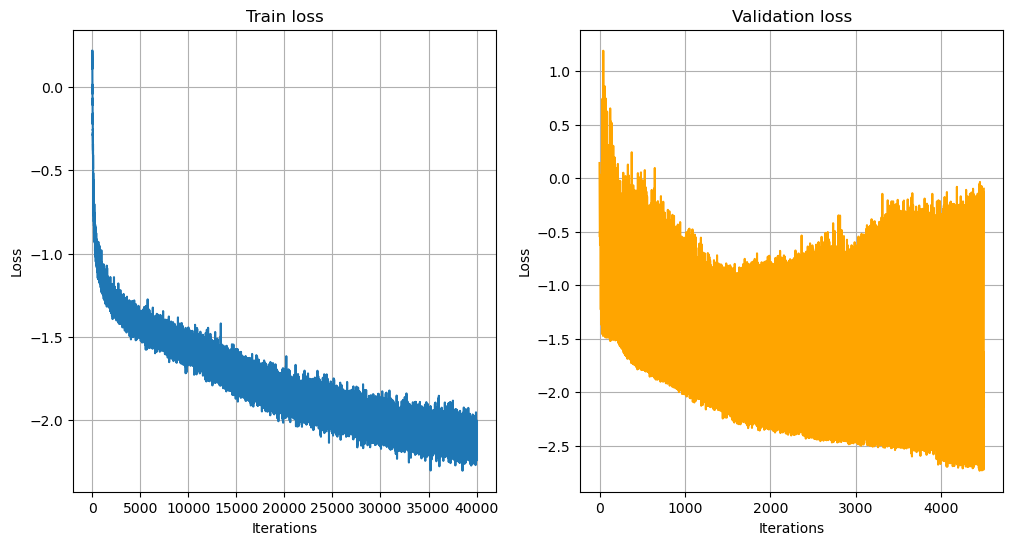

  0%|          | 0/5000 [00:00<?, ?it/s]

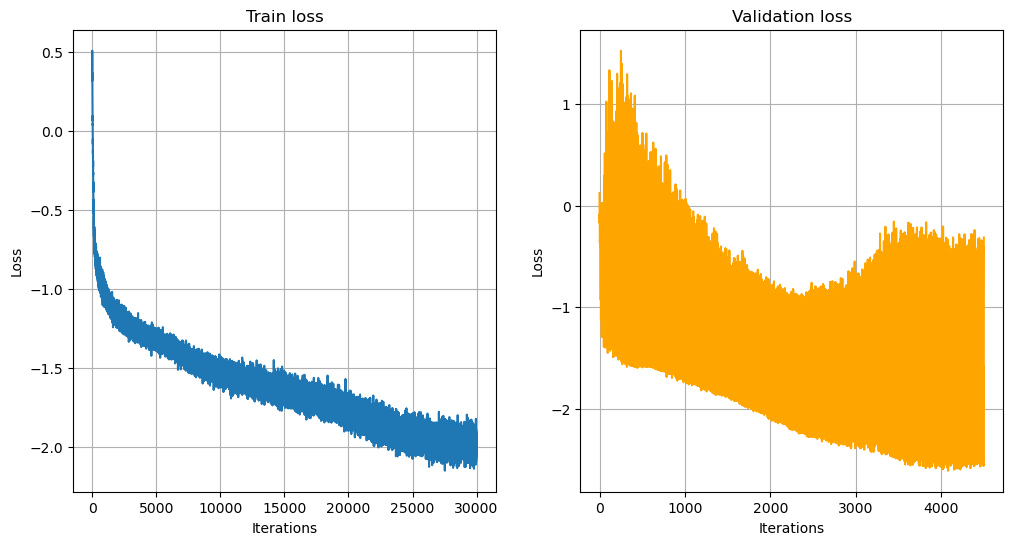

In [19]:
# train MIMO model with M = [2,3,4, 5]

Ms = [2, 3, 4, 5]

for M in Ms:
    MIMO_model = VarMIMONetwork(n_subnetworks=M)
    MIMO_model.apply(init_weights)
    
    optimizer = torch.optim.Adam(MIMO_model.parameters(), lr=3e-4)

    trainloader = DataLoader(traindata, batch_size=60*M, shuffle=True, collate_fn=lambda x: train_collate_fn(x, M), drop_last=True)
    valloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)

    losses, val_losses = train_var_regression(MIMO_model, optimizer, epochs=5000, trainloader=trainloader, valloader=valloader, val_every_n_epochs=10, model_name=f'varmimo_ensembles/VarMIMO_{M}_members')
    # plot loss 
    plot_loss(losses, val_losses)

  0%|          | 0/5000 [00:00<?, ?it/s]

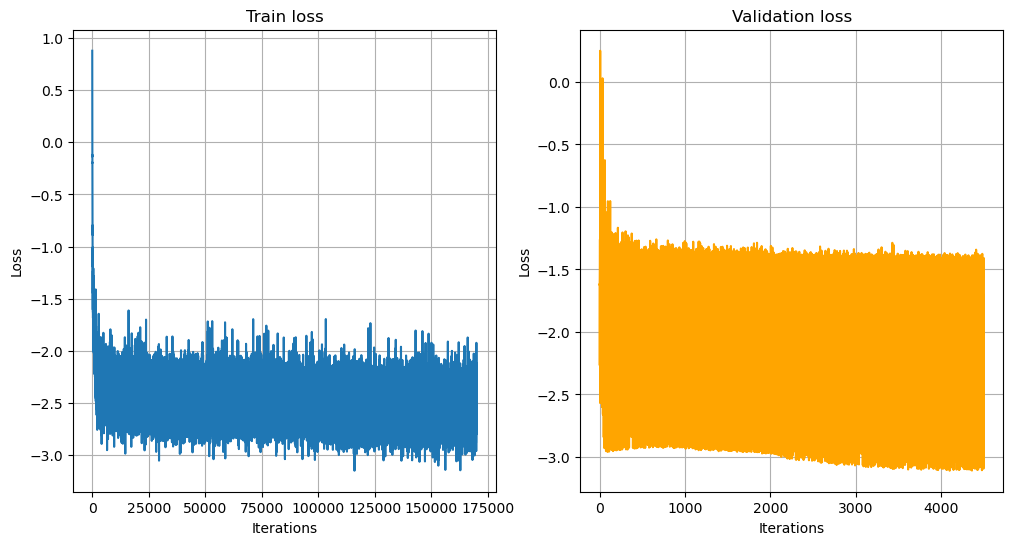

  0%|          | 0/5000 [00:00<?, ?it/s]

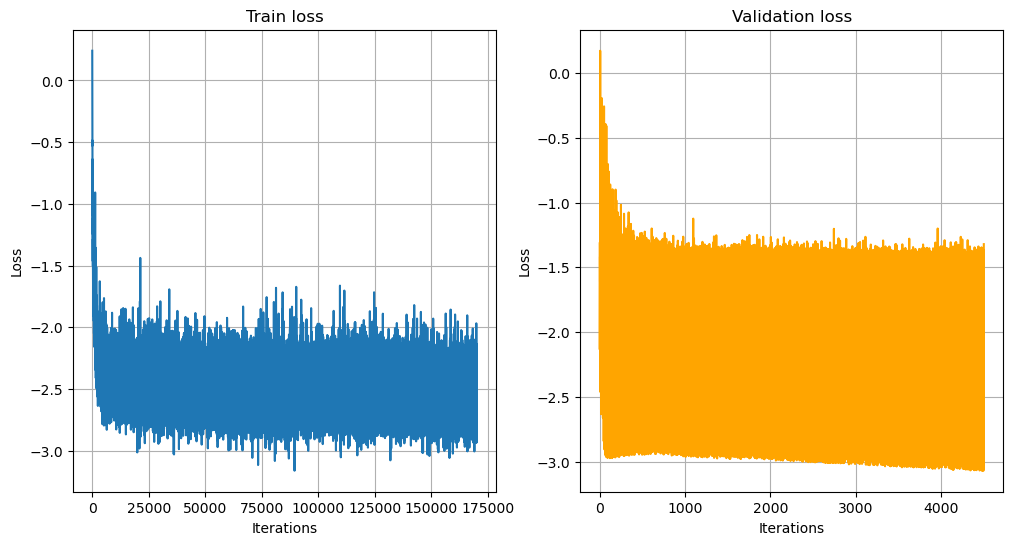

  0%|          | 0/5000 [00:00<?, ?it/s]

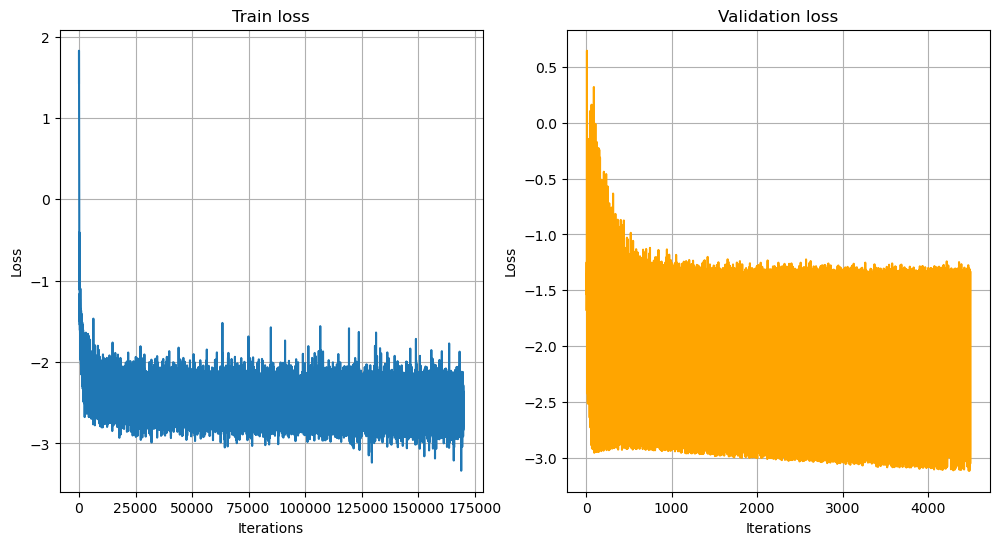

  0%|          | 0/5000 [00:00<?, ?it/s]

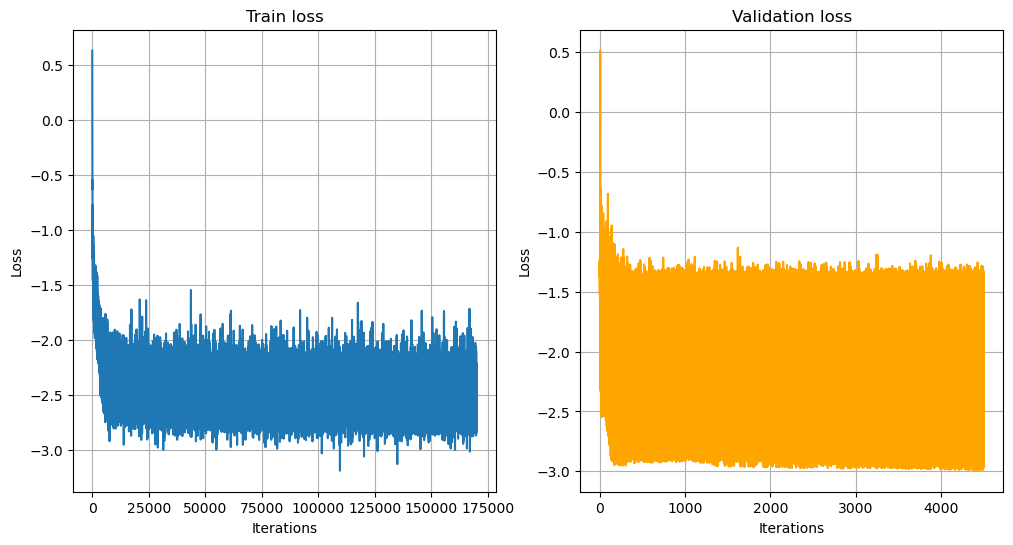

In [37]:
# train Naive model with M = [2,3,4]
Ms = [2, 3, 4, 5]

for M in Ms:
    naive_model = VarNaiveNetwork(n_subnetworks=M)
    naive_model.apply(init_weights)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=3e-4)

    naivetrainloader = DataLoader(traindata, batch_size=60, shuffle=True, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)
    naivevalloader = DataLoader(valdata, batch_size=60, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)

    losses, val_losses = train_var_regression(naive_model, optimizer, epochs=5000, trainloader=naivetrainloader, valloader=naivevalloader, val_every_n_epochs=10, model_name=f'varnaive_ensembles/VarNaive_{M}_members')
    # plot loss 
    plot_loss(losses, val_losses)


# Inference
We test the model on the test set and try to predict the function. We predict the mean outputs (of ensemble member) and of individual members.

In [59]:
def var_inference(model, testloader):
    mu_list = []
    sigma_list = []
    mus_list = []
    sigmas_list = []

    for test_x, test_y in testloader:
        mu, sigma, mus, sigmas = model(test_x.float())
        
        mu_list.extend(list(mu.detach().numpy()))
        sigma_list.extend(list(sigma.detach().numpy()))
        mus_list.extend(list(mus.detach().numpy()))
        sigmas_list.extend(list(sigmas.detach().numpy()))

    return np.array(mu_list), np.array(sigma_list), np.array(mus_list), np.array(sigmas_list)

# get predictions and individual predictions for MIMO and Naive models
def get_var_mimo_predictions(model_path, Ms, testdata, N_test=200):

    mu_matrix = np.zeros((len(model_path), N_test))
    sigma_matrix = np.zeros((len(model_path), N_test))
    mu_individual_list = []
    sigma_individual_list = []


    for i, model in enumerate(model_path):

        M = Ms[i]
        testloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=lambda x: test_collate_fn(x, M), drop_last=False)

        model = torch.load(model)
        mu, sigma, mus, sigmas = var_inference(model, testloader)

        mu_matrix[i, :] = mu
        sigma_matrix[i, :] = sigma
        mu_individual_list.append(mus)
        sigma_individual_list.append(sigmas)
            
    return mu_matrix, sigma_matrix, mu_individual_list, sigma_individual_list

def get_var_naive_predictions(model_path, Ms, testdata, N_test=200):

    mu_matrix = np.zeros((len(model_path), N_test))
    sigma_matrix = np.zeros((len(model_path), N_test))
    mu_individual_list = []
    sigma_individual_list = []


    for i, model in enumerate(model_path):

        M = Ms[i]
        testloader = DataLoader(testdata, batch_size=N_test, shuffle=False, collate_fn=lambda x: naive_collate_fn(x, M), drop_last=False)

        model = torch.load(model)
        mu, sigma, mus, sigmas = var_inference(model, testloader)

        mu_matrix[i, :] = mu
        sigma_matrix[i, :] = sigma
        mu_individual_list.append(mus)
        sigma_individual_list.append(sigmas)
            
    return mu_matrix, sigma_matrix, mu_individual_list, sigma_individual_list


Ms = [2, 3, 4, 5]

mimo_path = [os.path.join("varmimo_ensembles/", model) for model in ['VarMIMO_2_members.pt', 'VarMIMO_3_members.pt', 'VarMIMO_4_members.pt', 'VarMIMO_5_members.pt']]
mu, sigma, mus, sigmas = get_var_mimo_predictions(model_path=mimo_path, Ms = Ms, N_test=N_test, testdata=testdata)

naive_path = [os.path.join("varnaive_ensembles/", model) for model in ['VarNaive_2_members.pt', 'VarNaive_3_members.pt', 'VarNaive_4_members.pt', 'VarNaive_5_members.pt']]
naive_mu, naive_sigma, naive_mus, naive_sigmas = get_var_naive_predictions(model_path=naive_path, Ms = Ms, N_test=N_test, testdata=testdata)

In [60]:
def compute_statistics(mu, sigma, y_test):
    mse = np.power(mu - y_test, 2)
    expected_mse = np.mean(mse, axis=1)
    andersen_fu_divergence = np.mean(mse - np.power(sigma, 2), axis=1)

    return expected_mse, andersen_fu_divergence

mmse, afd = compute_statistics(mu, sigma, y_test)
naive_mmse, naive_afd = compute_statistics(naive_mu, naive_sigma, y_test)


In [61]:
mmse

array([0.06196738, 0.07271727, 0.17102262, 0.15287777])

In [62]:
afd

array([-0.4674046 , -0.17999723, -0.2718816 , -0.18179355])

**Analysis**

We need to analyse the trained network to see if the MIMO network works as desired. We plot the mean predictions of each model and the 95% confidence intervals using the standard deviation computed 

In [63]:
mu.shape

(4, 500)

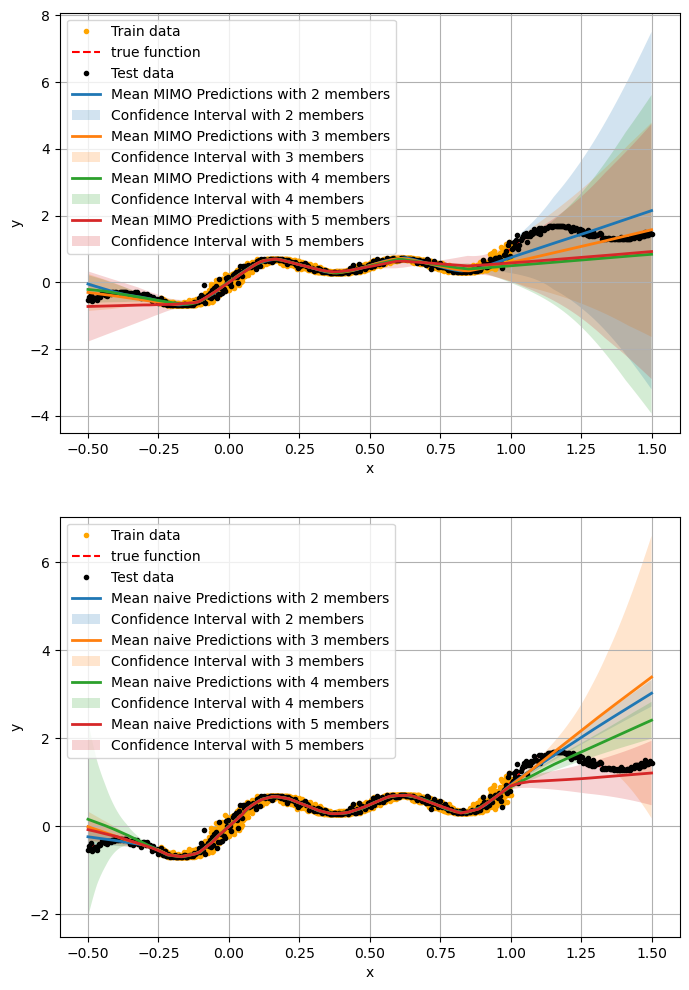

In [68]:
# plot data
fig, ax = plt.subplots(2,1, figsize=(8,12))

### plot mimo ###
ax[0].plot(x, y, '.', label='Train data', color='orange')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid()
ax[0].plot(x_test, line, '--', label='true function', color='red')
# plot test data
ax[0].plot(x_test, y_test, '.', label='Test data', color='black')

# plot predicitons with confidence intervals
for i in range(len(Ms)):
    ax[0].plot(x_test, mu[i], '-', label=f'Mean MIMO Predictions with {Ms[i]} members', linewidth=2)
    ax[0].fill_between(x_test, mu[i] - 1.96*sigma[i], mu[i] + 1.96*sigma[i], alpha=0.2, label=f'Confidence Interval with {Ms[i]} members')

ax[0].legend()

### naive ###
ax[1].plot(x, y, '.', label='Train data', color='orange')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].grid()
ax[1].plot(x_test, line, '--', label='true function', color='red')
# plot test data
ax[1].plot(x_test, y_test, '.', label='Test data', color='black')

# # plot predicitons with confidence intervals
for i in range(len(Ms)):
    ax[1].plot(x_test, naive_mu[i], '-', label=f'Mean naive Predictions with {Ms[i]} members', linewidth=2)
    ax[1].fill_between(x_test, naive_mu[i] - 1.96*naive_sigma[i], naive_mu[i] + 1.96*naive_sigma[i], alpha=0.2, label=f'Confidence Interval with {Ms[i]} members')
ax[1].legend()


plt.show()


The plot shows the mean predictions for the MIMO and naive models with $M=[2,3,4]$ ensemble members, illustrated with a 95% confidence interval. 
The confidence interval is constructed using the variance of individual predictions for each subnetwork in a model:


# Classification
We now move on to the classification task. To keep close to the MIMO paper we use CIFAR-10 for data:

We try to follow the SmallCNN example from Fort et al. that is also used in the MIMO paper. Some parts are not well described in the paper, such as the exact structure of the input and output layers. So we have simply made some decision that we think are appropriate in those regards.

In [14]:
#load/download CIFAR10
# https://github.com/kuangliu/pytorch-cifar/issues/19 normalisation values
transform = transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

CIFAR_traindata = torchvision.datasets.CIFAR10(root="../data/", train=True, transform = transform, download=False)
CIFAR_train, CIFAR_val = torch.utils.data.random_split(CIFAR_traindata, [int(len(CIFAR_traindata)*0.9), int(len(CIFAR_traindata)*0.1)])

CIFAR_test = torchvision.datasets.CIFAR10(root="../data/", train=False, transform = transform, download=False)


Images from the CIFAR10 dataset are 32x32 colour images. Below, some examples are visualised with their label. 

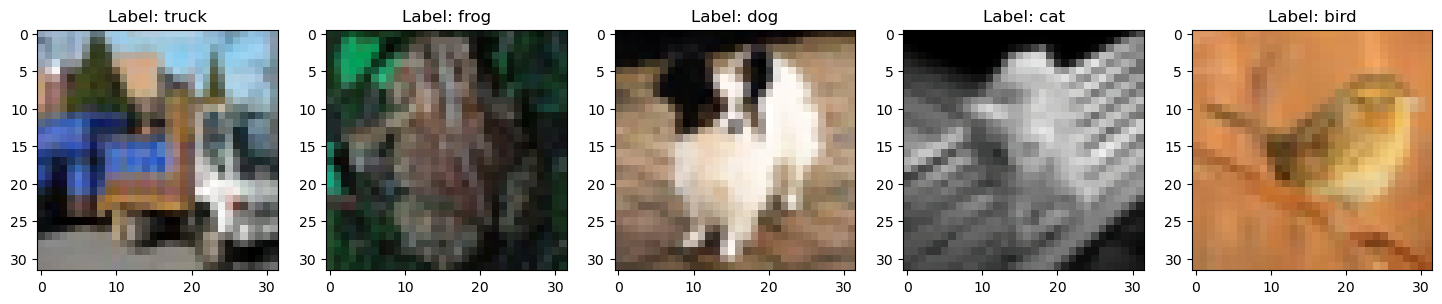

In [15]:
inv_transform = transforms.Normalize(mean=[-0.4914/0.247, -0.4822/0.243, -0.4465/0.261], std=[1/0.247, 1/0.243, 1/0.261])
label_dict = {0: "airplane", 
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"}

# plot some images
fig, ax = plt.subplots(1,5, figsize=(18,12))

for i in range(5):
    x, y = CIFAR_train[i]
    img = inv_transform(x) # unnormalise
    ax[i].imshow(img.permute(1,2,0))
    ax[i].set_title(f'Label: {label_dict[y]}')

In the [Github repository](https://github.com/google/edward2/blob/7a11c9782b1e72eef8e2f4fe7914827b799b692f/experimental/mimo/imagenet_model.py#L132-L138) they use the following operations to manipulate the input shape of ImageNet images:

In [16]:
M = 3
input_shape = (M, 32, 32, 3)
input_shape = list(input_shape)
inp = torch.ones(input_shape)
x = inp.permute(1,2,3,0)
x = torch.ones(list(input_shape[1:-1]) + [input_shape[-1] * M])

print(x.shape)

torch.Size([32, 32, 9])


In order to apply this to the CIFAR10 dataset, we extrapolate that we need to concatenate the ``ensemble_size`` dimension and channel dimension. This is what we will do in the collate functions below.

The collate function needs to be different for the CIFAR data. Pytorch has built-in CIFAR dataset so no dataset class is needed. The collate function is responsible for drawing M samples at a time so that each of the subnetworks gets a different input during training and the same input during inference.

During training, the input image $x$ naturally has shape $(batch\_size \cdot M, C, H, W)$ and the input label has shape $(batch\_size \cdot M). With the collate fucntion during training, the input image and label is split into $M$ chunks and concatenated in the channel dimension (dim = 1). 

With the collate function during testing, the input image and label is duplicated $M$ times in dim 1. 

In [17]:
#Collate functions
def C_train_collate_fn(batch, M):
    """Collate function for training MIMO on CIFAR classification"""
    
    x, y = zip(*batch)

    x, y = torch.stack(list(x)), torch.tensor(y)
    x = torch.cat(torch.chunk(x, M, dim=0), dim=1)
    y = torch.stack(torch.chunk(y, M, dim=0), dim=1)

    return x, y

def C_test_collate_fn(batch, M):
    """Collate function for testing MIMO on CIFAR classification"""
    
    x, y = zip(*batch)
    x, y = torch.stack(list(x)), torch.tensor(y)
    x = x.repeat(1, M, 1, 1)
    y = y[:,None].repeat(1,M)
    
    return x, y

def C_Naive_train_collate_fn(batch, M):
    """Collate function for training Naive multiheaded on CIFAR classification"""

    x, y = zip(*batch)

    x, y = torch.stack(list(x)), torch.tensor(y)
    y = y[:,None].repeat(1,M)

    return x, y

def C_Naive_test_collate_fn(batch, M):
    """Collate function for testing Naive multiheaded on CIFAR classsification"""

    x, y = zip(*batch)
    x, y = torch.stack(list(x)), torch.tensor(y)
    y = y[:,None].repeat(1,M)

    return x, y

The network is constructed in the following way:
- The input is put through $3$ convolutions with channels going from $3 \rightarrow 16$, $16 \rightarrow 32$, $32 \rightarrow 32$
- the output from the convolutions should be shape $( batch\_size, 32, 32, 32)$, because we use ``padding=1``. This is then flattened before being inputted into the linear layer
- after convolution there are $2$ linear layers where the dimensions is reduced down to $M\cdot 10$ - 10 for each class, for each subnetwork'

In the forward pass, the output are LogSoftmax probabilities. 

A separate ``ìnference`` function is created to output the actual predictions of 1) individual subnetworks and 2) the ensemble as a whole.

In [18]:
# Initialise Network
class C_MIMONetwork(nn.Module):
    def __init__(self, n_subnetworks):
        super().__init__()
        self.n_subnetworks = n_subnetworks
        self.in_channels = 3
        self.channels1 = 16
        self.channels2 = 32

        self.conv = torch.nn.Sequential(
            nn.Conv2d(self.in_channels*self.n_subnetworks, self.channels1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels1, self.channels2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels2, self.channels2, 3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.output = torch.nn.Sequential(
            nn.Linear(self.channels2 * 32 * 32, 128), # dim: self.channels2 x width x height
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, self.n_subnetworks*10)
        )

    def forward(self, x):

        x = self.conv(x)
        # reshape to fit into linear layer
        x = x.reshape(x.size(0), -1)
        x = self.output(x)

        # reshape to batch_size x M x 10
        x = x.reshape(x.size(0), self.n_subnetworks, -1)
        # Log-softmax over the last dimension (because we are using NLL loss)
        x = nn.LogSoftmax(dim=2)(x)

        # get individual outputs 
        # during training, we want each subnetwork to to clasify their corresponding inputs
        individual_outputs = torch.argmax(x, dim=2) # dim : batch_size x M
        
        # get ensemble output
        # during inference, we mean the softmax probabilities over all M subnetworks and then take the argmax
        output = torch.mean(x, dim=1).argmax(dim=1) # dim : batch_size
        
        x = x.permute(1,0,2)

        return x, output, individual_outputs

    # def inference(self, x):

    #     x = self.conv(x)
    #     # reshape to fit into linear layer
    #     x = x.reshape(x.size(0), -1)
    #     x = self.output(x)

    #     # reshape to batch_size x M x 10
    #     x = x.reshape(x.size(0), M, -1)
    #     # Log-softmax over the last dimension (because we are using NLL loss)
    #     x = nn.LogSoftmax(dim=2)(x)

    #     # get individual outputs 
    #     # during training, we want each subnetwork to to clasify their corresponding inputs
    #     individual_outputs = torch.argmax(x, dim=2) # dim : batch_size x M
        
    #     # get ensemble output
    #     # during inference, we mean the softmax probabilities over all M subnetworks and then take the argmax
    #     output = torch.mean(x, dim=1).argmax(dim=1) # dim : batch_size

    #     return output, individual_outputs

In [19]:
# Initialise Network
class C_NaiveNetwork(nn.Module):
    def __init__(self, n_subnetworks):
        super().__init__()
        self.n_subnetworks = n_subnetworks
        self.in_channels = 3
        self.channels1 = 16
        self.channels2 = 32

        self.conv = torch.nn.Sequential(
            nn.Conv2d(self.in_channels, self.channels1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels1, self.channels2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.channels2, self.channels2, 3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.output = torch.nn.Sequential(
            nn.Linear(self.channels2 * 32 * 32, 128), # dim: self.channels2 x width x height
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, self.n_subnetworks*10)
        )

    def forward(self, x):

        x = self.conv(x)
        # reshape to fit into linear layer
        x = x.reshape(x.size(0), -1)
        x = self.output(x)

        # reshape to batch_size x M x 10
        x = x.reshape(x.size(0), self.n_subnetworks, -1)
        # Log-softmax over the last dimension (because we are using NLL loss)
        x = nn.LogSoftmax(dim=2)(x)
        
        # get individual outputs 
        # during training, we want each subnetwork to to clasify their corresponding inputs
        individual_outputs = torch.argmax(x, dim=2) # dim : batch_size x M
        
        # get ensemble output
        # during inference, we mean the softmax probabilities over all M subnetworks and then take the argmax
        output = torch.mean(x, dim=1).argmax(dim=1) # dim : batch_size

        x = x.permute(1,0,2)

        return x, output, individual_outputs


In [20]:
# seed workers for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# train on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [21]:
def train_classification(model, optimizer, trainloader, valloader, epochs=500, model_name='MIMO', val_every_n_epochs=10, checkpoint_every_n_epochs=20, loss_fn = nn.NLLLoss(reduction='mean'), device='cpu'):
    losses = []
    val_losses = []
    val_checkpoint_list = []

    best_val_loss = np.inf

    for e in tqdm(range(epochs)):
        
        for x_, y_ in trainloader:

            x_,y_ = x_.float().to(device), y_.long().to(device)

            model.train()

            optimizer.zero_grad()

            log_prob, _, _ = model(x_)
            
            # sum loss per subnetwork
            # mean is already taken over the batch, because we use reduction = 'mean' in the loss function
            loss = 0
            for log_p, y in zip(log_prob, y_.T):
                # print(log_p.shape)
                # print(y.shape)
                loss += loss_fn(log_p, y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())  

        if (e+1) % val_every_n_epochs == 0:
            model.eval()

            val_loss_list = []
            
            with torch.no_grad():
                for val_x, val_y in valloader:
                    val_x, val_y = val_x.float().to(device), val_y.long().to(device)
                    log_prob, _, _ = model(val_x)
                
                    val_loss = 0
                    for log_p, y in zip(log_prob, val_y.T):
                        val_loss += loss_fn(log_p, y)

                    val_loss_list.append(val_loss.item())
                if (e+1) % checkpoint_every_n_epochs == 0:
                    val_checkpoint_list.append(log_prob[0,:,:])

            val_losses.extend(val_loss_list)
            mean_val_loss = np.mean(val_loss_list)
            if mean_val_loss < best_val_loss:
                best_val_loss = mean_val_loss
                torch.save(model, f'{model_name}_{model.n_subnetworks}.pt')
            # print(f"Mean validation loss at epoch {e}: {mean_val_loss}")
    torch.save(torch.stack(val_checkpoint_list), f'{model_name}_{model.n_subnetworks}_checkpoints.pt')

    return losses, val_losses, val_checkpoint_list


  0%|          | 0/30 [00:00<?, ?it/s]

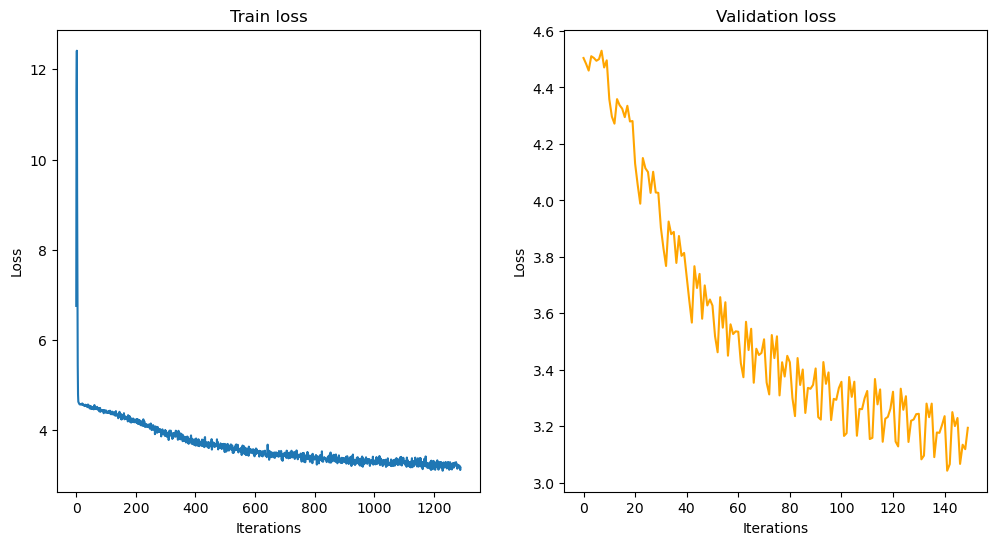

  0%|          | 0/30 [00:00<?, ?it/s]

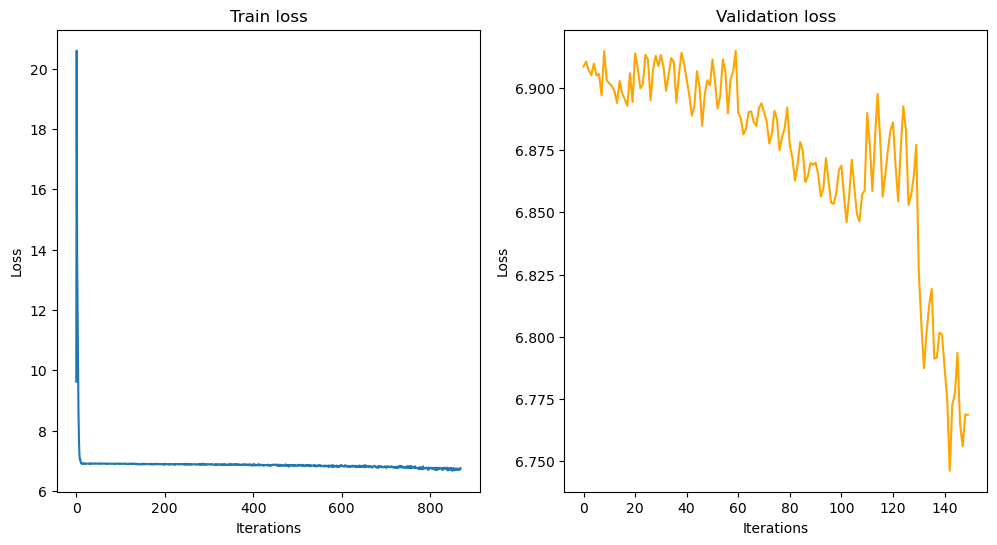

  0%|          | 0/30 [00:00<?, ?it/s]

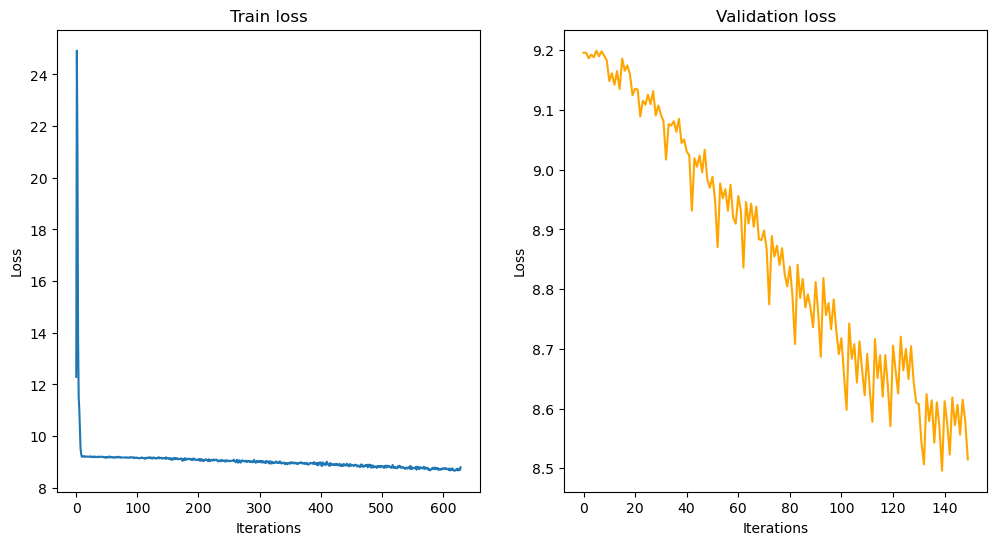

In [23]:
# train classification MIMO model with M = [2,3,4]

loss_fn = nn.NLLLoss(reduction='mean')
Ms = [2, 3, 4]
batch_size = 512

for M in Ms:
    C_MIMO_model = C_MIMONetwork(n_subnetworks=M)
    C_MIMO_model.apply(init_weights)
    C_MIMO_model = C_MIMO_model.to(device)
    
    optimizer = torch.optim.Adam(C_MIMO_model.parameters(), lr=3e-4)
    
    C_trainloader = DataLoader(CIFAR_train, batch_size=batch_size*M, shuffle=True, collate_fn=lambda x: C_train_collate_fn(x, M), drop_last=True, worker_init_fn=seed_worker, generator=g)
    C_valloader = DataLoader(CIFAR_val, batch_size=batch_size, shuffle=False, collate_fn=lambda x: C_test_collate_fn(x, M), drop_last=False)

    losses, val_losses, val_checkpoint_list = train_classification(C_MIMO_model, optimizer, C_trainloader, C_valloader, epochs=30, model_name='C_MIMO', val_every_n_epochs=2, checkpoint_every_n_epochs=20, loss_fn = loss_fn, device=device)
    # plot loss 
    plot_loss(losses, val_losses)

  0%|          | 0/30 [00:00<?, ?it/s]

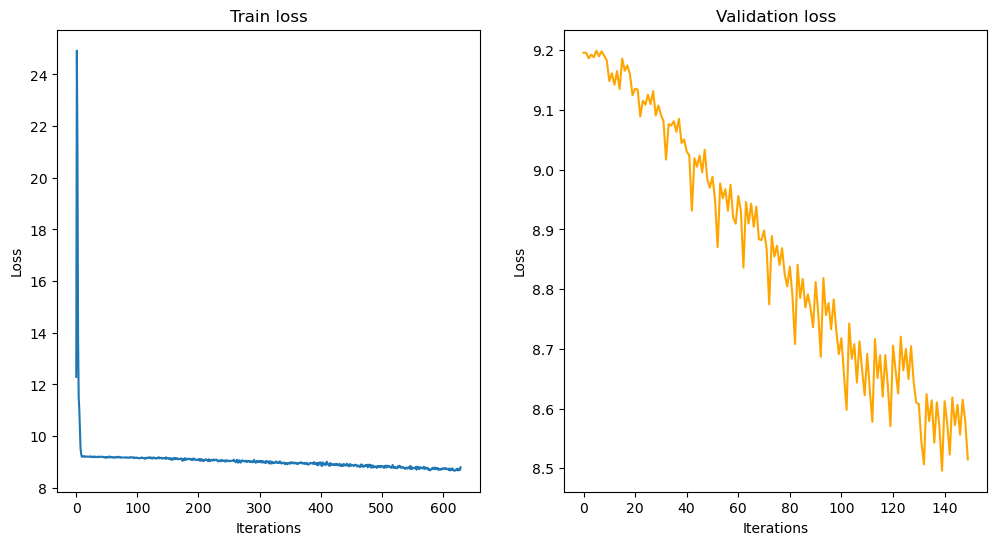

  0%|          | 0/30 [00:00<?, ?it/s]

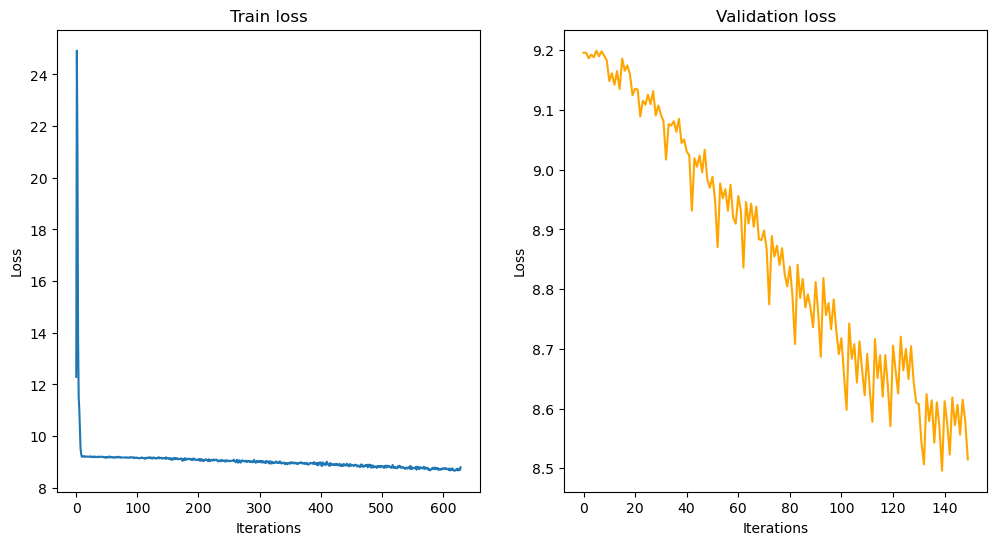

  0%|          | 0/30 [00:00<?, ?it/s]

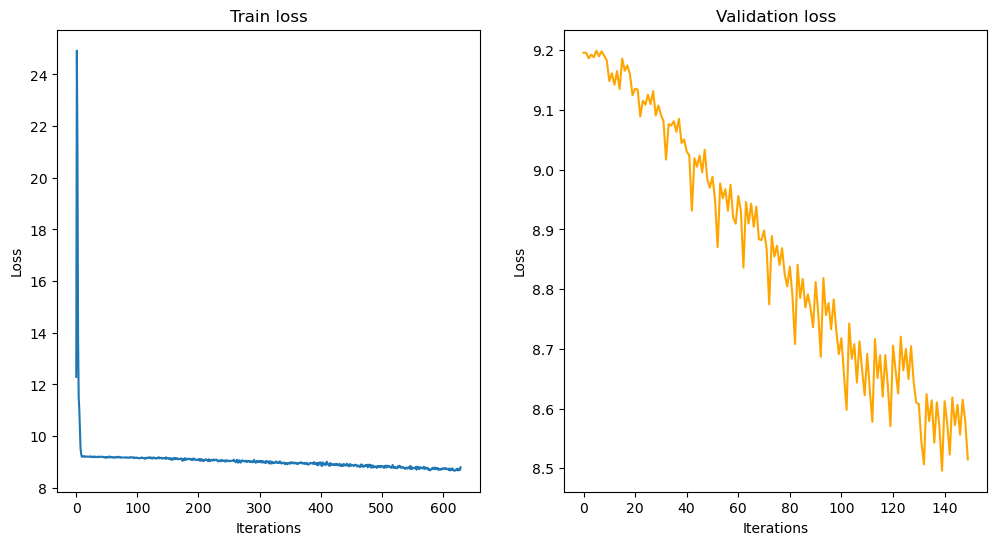

In [24]:
# train classification Naive model with M = [2,3,4]

loss_fn = nn.NLLLoss(reduction='mean')
Ms = [2, 3, 4]
batch_size = 512

for M in Ms:
    C_Naive_model = C_NaiveNetwork(n_subnetworks=M)
    C_Naive_model.apply(init_weights)
    C_Naive_model = C_Naive_model.to(device)
    
    Naive_optimizer = torch.optim.SGD(C_Naive_model.parameters(), lr=1e-3, weight_decay=3e-4)
    
    C_Naive_trainloader = DataLoader(CIFAR_train, batch_size=batch_size, shuffle=True, collate_fn=lambda x: C_Naive_train_collate_fn(x, M), drop_last=True, worker_init_fn=seed_worker, generator=g)
    C_Naive_valloader = DataLoader(CIFAR_val, batch_size=batch_size, shuffle=False, collate_fn=lambda x: C_Naive_test_collate_fn(x, M), drop_last=False)

    naive_losses, naive_val_losses, val_checkpoint_list = train_classification(C_Naive_model, Naive_optimizer, C_Naive_trainloader, C_Naive_valloader, epochs=30, model_name="C_Naive", val_every_n_epochs=2, checkpoint_every_n_epochs=20, loss_fn = loss_fn, device=device)
    # plot loss 
    plot_loss(losses, val_losses)

# Inference

We will predict on the test images.

In [25]:
batch_size = 512
C_testloader = DataLoader(CIFAR_test, batch_size=batch_size, shuffle=False, collate_fn=lambda x: C_test_collate_fn(x, M), drop_last=False)
C_Naive_testloader = DataLoader(CIFAR_test, batch_size=batch_size, shuffle=False, collate_fn=lambda x: C_Naive_test_collate_fn(x, M), drop_last=False)

In [29]:
# weight distribution

weights_mimo = []
for param in C_MIMO_model.parameters():
    weights_mimo.extend(param.flatten().cpu().detach().numpy())

weights_naive = []
for param in C_Naive_model.parameters():
    weights_naive.extend(param.flatten().cpu().detach().numpy())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.hist(weights_mimo, bins=50, alpha=0.5, label='MIMO_model')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Weight Distribution - Classification MIMO Model')

ax2.hist(weights_naive, bins=50, alpha=0.5, label='naive_model')
ax2.set_xlabel('Weight Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Weight Distribution - Classification Naive Model')

plt.tight_layout()
plt.show()

NameError: name 'C_Naive_model' is not defined

In [34]:
C_mimo_path = [os.path.join("C_mimo_ensembles/", model) for model in ['C_MIMO_2.pt', 'C_MIMO_3.pt', 'C_MIMO_4.pt']]

for i, model in enumerate(C_mimo_path):
    M = i+2
    C_MIMO_model = torch.load(model)
    C_MIMO_model = C_MIMO_model.to(device)

    C_testloader = DataLoader(CIFAR_test, batch_size=batch_size, shuffle=False, collate_fn=lambda x: C_test_collate_fn(x, M), drop_last=False)

    predictions = []
    ground_truth = []
    confidence = []

    for x_test, y_test in C_testloader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        _, output, individual_outputs = C_MIMO_model.forward(x_test)
        
        predictions.extend(list(output.cpu().detach().numpy()))
        ground_truth.extend(list(y_test[:,0].cpu().detach().numpy()))

    accuracy = np.mean(np.array(predictions) == np.array(ground_truth))
    print(f"Accuracy for MIMO with {M} members:", accuracy)

Accuracy for MIMO with 2 members: 0.4563
Accuracy for MIMO with 3 members: 0.1791
Accuracy for MIMO with 4 members: 0.223


In [35]:
C_naive_path = [os.path.join("C_naive_ensembles/", model) for model in ['C_Naive_2.pt', 'C_Naive_3.pt', 'C_Naive_4.pt']]

for i, model in enumerate(C_naive_path):
    M = i+2
    C_Naive_model = torch.load(model)
    C_Naive_model = C_Naive_model.to(device)

    C_Naive_testloader = DataLoader(CIFAR_test, batch_size=batch_size, shuffle=False, collate_fn=lambda x: C_Naive_test_collate_fn(x, M), drop_last=False)

    naive_predictions = []
    naive_ground_truth = []
    naive_confidence = []

    for x_test, y_test in C_Naive_testloader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        _, output, individual_outputs = C_Naive_model.forward(x_test)
        
        naive_predictions.extend(list(output.cpu().detach().numpy()))
        naive_ground_truth.extend(list(y_test[:,0].cpu().detach().numpy()))

    accuracy = np.mean(np.array(naive_predictions) == np.array(naive_ground_truth))
    print(f"Accuracy for naive model with {M} members:", accuracy)

Accuracy for naive model with 2 members: 0.5314
Accuracy for naive model with 3 members: 0.5463
Accuracy for naive model with 4 members: 0.5558


***Plots for Image Classifiers***

We want to illustrate the overconfidence of the Image classifier models. To do this we make reliability diagrams as described in Gou et al. 

The reliability diagram has accuracy on the y-axis and confidence on the x-axis. We sample some test points, then bin them based on the models confidence in its prediction for those points. Thus we will have accuracy sorted in bins like so:
$$acc(B_m)=\frac{1}{|B_m|}\sum_{i\in B_m} \mathbf{1}(\hat{y}_i=y_i)$$
where $\mathbf{1}(\hat{y}_i=y_i)$ is an indicator function for a correct prediction and $B_m$ is the m-th bin of $M$ bins with width $\frac{1}{M}$.

The confidence is likewise calculated as 
$$conf(B_m)=\frac{1}{|B_m|}\sum_{i\in B_m} \hat{p}_i$$
where $\hat{p_i}$ is the confidence for sample $i$. In this case, since we have no better measure, the softmax probabilities will be used as confidence scores.

A perfectly calibrated model will have $acc(B_m) = conf(B_m)$ but since neural networks are typically overconfident we will expect to see $acc(B_m) < conf(B_m)$


In [123]:
#Code for generating reliability diagram:
bins_range = np.arange(0, 1, 0.1)
conf_step_height = np.zeros(10)
acc_step_height = np.zeros(10)
for i in range(len(bins_range)-1):
    loc = np.where(confidence>=bins_range[i] and confidence<bins_range[i+1])
    conf_step_height[i] = np.mean(confidence[loc])
    acc_step_height[i] = np.mean(accuracy[loc])




naive_conf_step_height = np.zeros(10)
naive_acc_step_height = np.zeros(10)
for i in range(len(bins_range)-1):
    loc = np.where(naive_confidence>=bins_range[i] and naive_confidence<bins_range[i+1])
    naive_conf_step_height[i] = np.mean(confidence[loc])
    naive_acc_step_height[i] = np.mean(accuracy[loc])



ax, fig = plt.subplots(2,1, sharey=True)
ax.set_xlabel("Confidence")
ax.set_ylabel("Accuracy")
ax[0].stairs(conf_step_height, bins_range, hatch="//")
ax[0].stairs(acc_step_height, bins_range, fill = True)
ax[0].set_title("Reliability Plot MIMO")

ax[1].stairs(conf_step_height, bins_range, hatch="//", legend='Gap')
ax[1].stairs(acc_step_height, bins_range, fill = True, legend="Outputs")
ax[1].set_title("Reliability Plot Naive Multiheaded")
plt.show()

C:\Users\Yucheng\AppData\Local\Temp\ipykernel_17584\3845656734.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  loc = np.where(confidence>=bins_range[i] and confidence<bins_range[i+1])


TypeError: list indices must be integers or slices, not tuple

In order to observe the diversity of the subnetworks in the MIMO model, we use function space plots like in Fort et al.
This lets us visualize how each subnetwork moves in function space.

The plots are made with the following steps:
- At certain model checkpoints, get softmax predictions and use tSNE to reduce the softmaxoutput to 2d so that you can plot it.
- first separate checkpoint output so that each subnetwork is isolated
- then apply the same t-SNE algorithm to all of them
- then plot them together

tips:
- TNSE works best with a reasonable dimensionality (around 50 dimensions) [citation needed] so we limit the number of predictions. We have a large batch size and 10 class prediction pr data-point. Consider this when selecting how many predictions to keep.


In [ ]:
print(val_checkpoint_list.shape)


In [124]:
val_checkpoint_list = torch.stack(val_checkpoint_list[:,:5,:]).flatten()
tSNE = TSNE(val_checkpoint_list.shape)
val_checkpoint_list2d = tSNE.fit_transform(val_checkpoint_list)
plt.plot(val_checkpoint_list)



TypeError: list indices must be integers or slices, not tuple

In [129]:
torch.stack(val_checkpoint_list).shape

torch.Size([15, 392, 10])

In [132]:
512*392

200704

In [131]:
val_checkpoint_list[0].shape

torch.Size([392, 10])